# 畳み込み層を使ったAuto Encoder

**わかったこと**

チャンネル数を大きくすると精度向上につながる

畳み込み層だと特徴を抽出できるのは

→フィルターを入力データに適用することで、局所的な特徴を抽出することができ、プーリング層を用いて特徴マップを縮小することで、計算量を削減し、特徴をより一般的なものにまとめられるから

In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = CIFAR10('./data', train=True, transform=transform, download=True)
testset = CIFAR10('./data', train=False, transform=transform, download=True)

batch_size = 50
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size // 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
conv2 = torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
pool = torch.nn.MaxPool2d(2)

In [4]:
iterator = iter(trainloader)
x, _ = next(iterator)

print(x.shape)
x = conv1(x)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = torch.relu(x)
x = pool(x)
print(x.shape)

torch.Size([50, 3, 32, 32])
torch.Size([50, 16, 32, 32])
torch.Size([50, 16, 16, 16])
torch.Size([50, 8, 16, 16])
torch.Size([50, 8, 8, 8])


In [5]:
enc = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16, 8, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2)
)

In [6]:
dec = torch.nn.Sequential(
    torch.nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
    torch.nn.Sigmoid()
)

In [7]:
class AutoEncoder2(torch.nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
    
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [10]:
def train(net, criterion, optimizer, epochs, trainloadere):
    losses = []
    output_and_label = []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    
    for epoch in range(1, epochs+1):
        print(f'epoch: {epoch},', end='')
        running_loss = 0.0
        for counter, (img, _) in enumerate(trainloader, 1):
            img = img.to(device)
            optimizer.zero_grad()
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        output_and_label.append((output, img))
    print('finished')
    return output_and_label, losses

In [11]:
net = AutoEncoder2(enc, dec)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
EPOCHS = 100
input_size = 3 * 32 * 32

output_and_label, losses = train(net, criterion, optimizer, EPOCHS, trainloader)

/home/komuro/anaconda3/envs/example/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


epoch: 1,loss: 0.2037242483496666
epoch: 2,loss: 0.17071104688942432
epoch: 3,loss: 0.16621432244777679
epoch: 4,loss: 0.1645258408933878
epoch: 5,loss: 0.1634069754332304
epoch: 6,loss: 0.16241663739085196
epoch: 7,loss: 0.15982306346297265
epoch: 8,loss: 0.156873025842011
epoch: 9,loss: 0.1559970441237092
epoch: 10,loss: 0.15550121665745972
epoch: 11,loss: 0.15514796628057956
epoch: 12,loss: 0.15486641086637973
epoch: 13,loss: 0.15462136901170015
epoch: 14,loss: 0.15440523434430362
epoch: 15,loss: 0.1542132938578725
epoch: 16,loss: 0.1540387191772461
epoch: 17,loss: 0.15387965416163207
epoch: 18,loss: 0.15373970380425453
epoch: 19,loss: 0.1536188006103039
epoch: 20,loss: 0.15351246874034405
epoch: 21,loss: 0.15341597750037908
epoch: 22,loss: 0.15332839038968085
epoch: 23,loss: 0.15324688141793014
epoch: 24,loss: 0.15317109261453152
epoch: 25,loss: 0.15310133539885282
epoch: 26,loss: 0.1530351159349084
epoch: 27,loss: 0.15297317916154862
epoch: 28,loss: 0.15291432923078538
epoch: 29,l

In [12]:
def imshow(img):
    img = torchvision.utils.make_grid(img)   #グリッド上に並べて1枚の画像とする
    img = img / 2 + 0.5
    npimg = img.detach().numpy()   #新しいテンソルを用意
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(3, 240, 274)


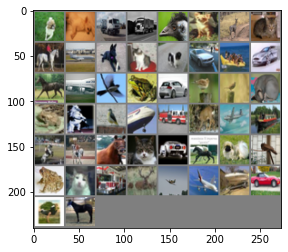

(3, 240, 274)


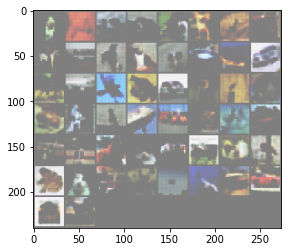

In [13]:
img, org = output_and_label[-1]
img = img.reshape(-1, 3, 32, 32)
org = org.reshape(-1, 3, 32, 32)
imshow(org)
imshow(img)

チャンネル数とカーネルサイズを大きくしたら表現力上がるのか

In [14]:
enc2 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, kernel_size=4, padding=1, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, kernel_size=4, padding=1, stride=2),
    torch.nn.ReLU()
)

dec2 = torch.nn.Sequential(
    torch.nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
    torch.nn.Tanh()
)

In [15]:
net = AutoEncoder2(enc2, dec2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
EPOCHS = 100
input_size = 3 * 32 * 32

output_and_label, losses = train(net, criterion, optimizer, EPOCHS, trainloader)

epoch: 1,loss: 0.04294625613838434
epoch: 2,loss: 0.018414932748302817
epoch: 3,loss: 0.013350377049297094
epoch: 4,loss: 0.010491580295842141
epoch: 5,loss: 0.0089792688973248
epoch: 6,loss: 0.008070775002241135
epoch: 7,loss: 0.007340813854243606
epoch: 8,loss: 0.006679086301941425
epoch: 9,loss: 0.006231986566912383
epoch: 10,loss: 0.005822647849330679
epoch: 11,loss: 0.005488420047797263
epoch: 12,loss: 0.005238590783439577
epoch: 13,loss: 0.004983874401310459
epoch: 14,loss: 0.004796054112259298
epoch: 15,loss: 0.004605267988052219
epoch: 16,loss: 0.004440348748350516
epoch: 17,loss: 0.004276615986367687
epoch: 18,loss: 0.004142333661904559
epoch: 19,loss: 0.004027483548037708
epoch: 20,loss: 0.003907818045467138
epoch: 21,loss: 0.0037927323130425065
epoch: 22,loss: 0.0037105421144515275
epoch: 23,loss: 0.0036035852467175573
epoch: 24,loss: 0.003529925829730928
epoch: 25,loss: 0.0034616593760438265
epoch: 26,loss: 0.0033592667593620716
epoch: 27,loss: 0.003276933867484331
epoch: 2

(3, 240, 274)


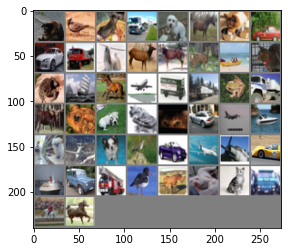

(3, 240, 274)


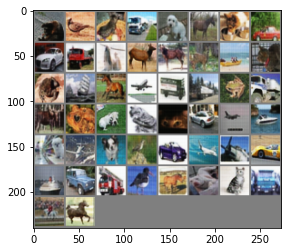

In [16]:
img, org = output_and_label[-1]
img = img.reshape(-1, 3, 32, 32)
org = org.reshape(-1, 3, 32, 32)
imshow(org)
imshow(img)

In [18]:
torch.save(net, 'conv.pt')

チャンネル数を増やすこととカーネルサイズを大きくすることが精度向上につながることがわかった